[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/snntorch_alpha_w.png?raw=true' width="300">](https://github.com/jeshraghian/snntorch/)
[<img src='https://github.com/neuromorphs/tonic/blob/develop/docs/_static/tonic-logo-white.png?raw=true' width="200">](https://github.com/neuromorphs/tonic/)


# Neuromorphic Datasets with Tonic + snnTorch
## Tutorial 7
### By Gregor Lenz (lenzgregor.com) and Jason K. Eshraghian (www.ncg.ucsc.edu)

<a href="https://colab.research.google.com/github/jeshraghian/snntorch/blob/master/examples/examples/tutorial_7_neuromorphic_datasets.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub-Mark-Light-120px-plus.png?raw=true' width="28">](https://github.com/jeshraghian/snntorch/) [<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub_Logo_White.png?raw=true' width="80">](https://github.com/jeshraghian/snntorch/)

The snnTorch tutorial series is based on the following paper. If you find these resources or code useful in your work, please consider citing the following source:

> <cite> [Jason K. Eshraghian, Max Ward, Emre Neftci, Xinxin Wang, Gregor Lenz, Girish Dwivedi, Mohammed Bennamoun, Doo Seok Jeong, and Wei D. Lu. "Training Spiking Neural Networks Using Lessons From Deep Learning". Proceedings of the IEEE, 111(9) September 2023.](https://ieeexplore.ieee.org/abstract/document/10242251) </cite>

# Introduction
In this tutorial, you will:
* Learn how to load neuromorphic datasets using [Tonic](https://github.com/neuromorphs/tonic)
* Make use of caching to speed up dataloading
* Train a CSNN with the [Neuromorphic-MNIST](https://tonic.readthedocs.io/en/latest/datasets.html#n-mnist) Dataset

If running in Google Colab:
* You may connect to GPU by checking `Runtime` > `Change runtime type` > `Hardware accelerator: GPU`
* Next, install the latest PyPi distribution of snnTorch and Tonic by clicking into the following cell and pressing `Shift+Enter`.

In [1]:
!pip install numpy
!pip install tonic --quiet
!pip install snntorch --quiet

In [ ]:
# --- Clean install for tonic + NumPy in Colab ---

# 1️⃣ Uninstall pre-installed NumPy
!pip uninstall -y numpy

# 2️⃣ Reinstall a compatible NumPy version
!pip install numpy==1.27.0

# 3️⃣ Reinstall tonic and dependencies
!pip install --upgrade --force-reinstall tonic snntorch

# 4️⃣ Restart runtime automatically (Colab requires restart to pick up new NumPy)
import os
os._exit(00)

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
ERROR: Ignored the following versions that require a different python version: 1.21.2 Requires-Python >=3.7,<3.11; 1.21.3 Requires-Python >=3.7,<3.11; 1.21.4 Requires-Python >=3.7,<3.11; 1.21.5 Requires-Python >=3.7,<3.11; 1.21.6 Requires-Python >=3.7,<3.11
ERROR: Could not find a version that satisfies the requirement numpy==1.27.0 (from versions: 1.3.0, 1.4.1, 1.5.0, 1.5.1, 1.6.0, 1.6.1, 1.6.2, 1.7.0, 1.7.1, 1.7.2, 1.8.0, 1.8.1, 1.8.2, 1.9.0, 1.9.1, 1.9.2, 1.9.3, 1.10.0.post2, 1.10.1, 1.10.2, 1.10.4, 1.11.0, 1.11.1, 1.11.2, 1.11.3, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 1.13.3, 1.14.0, 1.14.1, 1.14.2, 1.14.3, 1.14.4, 1.14.5, 1.14.6, 1.15.0, 1.15.1, 1.15.2, 1.15.3, 1.15.4, 1.16.0, 1.16.1, 1.16.2, 1.16.3, 1.16.4, 1.16.5, 1.16.6, 1.17.0, 1.17.1, 1.17.2, 1.17.3, 1.17.4, 1.17.5, 1.18.0, 1.18.1, 1.18.2, 1.18.3, 1.18.4, 1.18.5, 1.19.0, 1.19.1, 1.19.2, 1.19.3, 1.19.4, 1.19.5, 1.20.0, 1.20.1,

# 1. Using Tonic to Load Neuromorphic Datasets
Loading datasets from neuromorphic sensors is made super simple thanks to [Tonic](https://github.com/neuromorphs/tonic), which works much like PyTorch vision.

Let's start by loading the neuromorphic version of the MNIST dataset, called [N-MNIST](https://tonic.readthedocs.io/en/latest/reference/datasets.html#n-mnist). We can have a look at some raw events to get a feel for what we're working with.

In [2]:
import tonic

dataset = tonic.datasets.NMNIST(save_to='./data', train=True)
events, target = dataset[0]
print(events)

  0%|          | 0/1011893601 [00:00<?, ?it/s]

Extracting ./data/NMNIST/train.zip to ./data/NMNIST
[(10, 30,    937, 1) (33, 20,   1030, 1) (12, 27,   1052, 1) ...
 ( 7, 15, 302706, 1) (26, 11, 303852, 1) (11, 17, 305341, 1)]


Each row corresponds to a single event, which consists of four parameters: (*x-coordinate, y-coordinate, timestamp, polarity*).

* x & y co-ordinates correspond to an address in a $34 \times 34$ grid.

* The timestamp of the event is recorded in microseconds.

* The polarity refers to whether an on-spike (+1) or an off-spike (-1) occured; i.e., an increase in brightness or a decrease in brightness.

If we were to accumulate those events over time and plot the bins as images, it looks like this:

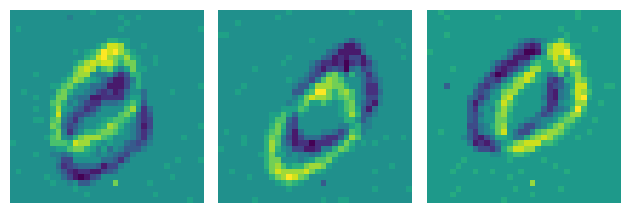

In [3]:
tonic.utils.plot_event_grid(events)

## 1.1 Transformations

However, neural nets don't take lists of events as input. The raw data must be converted into a suitable representation, such as a tensor. We can choose a set of transforms to apply to our data before feeding it to our network. The neuromorphic camera sensor has a temporal resolution of microseconds, which when converted into a dense representation, ends up as a very large tensor. That is why we bin events into a smaller number of frames using the [ToFrame transformation](https://tonic.readthedocs.io/en/latest/reference/transformations.html#frames), which reduces temporal precision but also allows us to work with it in a dense format.

* `time_window=1000` integrates events into 1000$~\mu$s bins

* Denoise removes isolated, one-off events. If no event occurs within a neighbourhood of 1 pixel across `filter_time` microseconds, the event is filtered. Smaller `filter_time` will filter more events.

In [4]:
import tonic.transforms as transforms

sensor_size = tonic.datasets.NMNIST.sensor_size

# Denoise removes isolated, one-off events
# time_window
frame_transform = transforms.Compose([transforms.Denoise(filter_time=10000),
                                      transforms.ToFrame(sensor_size=sensor_size,
                                                         time_window=1000)
                                     ])

trainset = tonic.datasets.NMNIST(save_to='./tmp/data', transform=frame_transform, train=True)
testset = tonic.datasets.NMNIST(save_to='./tmp/data', transform=frame_transform, train=False)

  0%|          | 0/1011893601 [00:00<?, ?it/s]

Extracting ./tmp/data/NMNIST/train.zip to ./tmp/data/NMNIST


  0%|          | 0/169674850 [00:00<?, ?it/s]

Extracting ./tmp/data/NMNIST/test.zip to ./tmp/data/NMNIST


In [5]:
def load_sample_simple():
    for i in range(100):
        events, target = trainset[i]

In [6]:
%timeit -o load_sample_simple()

1.79 s ± 338 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 1.79 s ± 338 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

## 1.2 Fast DataLoading


The original data is stored in a format that is slow to read. To speed up dataloading, we can make use of disk caching and batching. That means that once files are loaded from the original dataset, they are written to the disk.

Because event recordings have different lengths, we are going to provide a  collation function `tonic.collation.PadTensors()` that will pad out shorter recordings to ensure all samples in a batch have the same dimensions.

In [7]:
from torch.utils.data import DataLoader
from tonic import DiskCachedDataset

cached_trainset = DiskCachedDataset(trainset, cache_path='./cache/nmnist/train')
cached_dataloader = DataLoader(cached_trainset)

batch_size = 128
trainloader = DataLoader(cached_trainset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors())

In [8]:
def load_sample_batched():
    events, target = next(iter(cached_dataloader))

In [9]:
%timeit -o -r 10 load_sample_batched()

5.51 ms ± 79.4 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


<TimeitResult : 5.51 ms ± 79.4 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)>

By using disk caching and a PyTorch dataloader with multithreading and batching support, we have signifantly reduced loading times.

If you have a large amount of RAM available, you can speed up dataloading further by caching to main memory instead of to disk:

```
from tonic import MemoryCachedDataset

cached_trainset = MemoryCachedDataset(trainset)
```

# 2. Training our network using frames created from events

Now let's actually train a network on the N-MNIST classification task. We start by defining our caching wrappers and dataloaders. While doing that, we're also going to apply some augmentations to the training data. The samples we receive from the cached dataset are frames, so we can make use of PyTorch Vision to apply whatever random transform we would like.

In [10]:
import torch
import torchvision

transform = tonic.transforms.Compose([torch.from_numpy,
                                      torchvision.transforms.RandomRotation([-10,10])])

cached_trainset = DiskCachedDataset(trainset, transform=transform, cache_path='./cache/nmnist/train')

# no augmentations for the testset
cached_testset = DiskCachedDataset(testset, cache_path='./cache/nmnist/test')

batch_size = 128
trainloader = DataLoader(cached_trainset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False), shuffle=True)
testloader = DataLoader(cached_testset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False))

A mini-batch now has the dimensions (time steps, batch size, channels, height, width). The number of time steps will be set to that of the longest recording in the mini-batch, and all other samples will be padded with zeros to match it.

In [11]:
event_tensor, target = next(iter(trainloader))
print(event_tensor.shape)

torch.Size([311, 128, 2, 34, 34])


## 2.1 Defining our network
We will use snnTorch + PyTorch to construct a CSNN, just as in the previous tutorial. The convolutional network architecture to be used is: 12C5-MP2-32C5-MP2-800FC10

- 12C5 is a 5$\times$5 convolutional kernel with 12 filters
- MP2 is a 2$\times$2 max-pooling function
- 800FC10 is a fully-connected layer that maps 800 neurons to 10 outputs

In [12]:
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import spikeplot as splt
from snntorch import utils
import torch.nn as nn

In [13]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# neuron and simulation parameters
spike_grad = surrogate.atan()
beta = 0.5

#  Initialize Network
net = nn.Sequential(nn.Conv2d(2, 12, 5),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.MaxPool2d(2),
                    nn.Conv2d(12, 32, 5),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.MaxPool2d(2),
                    nn.Flatten(),
                    nn.Linear(32*5*5, 10),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
                    ).to(device)

In [14]:
# this time, we won't return membrane as we don't need it

def forward_pass(net, data):
  spk_rec = []
  utils.reset(net)  # resets hidden states for all LIF neurons in net

  for step in range(data.size(0)):  # data.size(0) = number of time steps
      spk_out, mem_out = net(data[step])
      spk_rec.append(spk_out)

  return torch.stack(spk_rec)

## 2.2 Training

In the previous tutorial, Cross Entropy Loss was applied to the total spike count to maximize the number of spikes from the correct class.

Another option from the `snn.functional` module is to specify the target number of spikes from correct and incorrect classes. The approach below uses the *Mean Square Error Spike Count Loss*, which aims to elicit spikes from the correct class 80\% of the time, and 20\% of the time from incorrect classes. Encouraging incorrect neurons to fire could be motivated to avoid dead neurons.

In [15]:
optimizer = torch.optim.Adam(net.parameters(), lr=2e-2, betas=(0.9, 0.999))
loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)

Training neuromorphic data is expensive as it requires sequentially iterating through many time steps (approximately 300 time steps in the N-MNIST dataset). The following simulation will take some time, so we will just stick to training across 50 iterations (which is roughly 1/10th of a full epoch). Feel free to change `num_iters` if you have more time to kill. As we are printing results at each iteration, the results will be quite noisy and will also take some time before we start to see any sort of improvement.

In our own experiments, it took about 20 iterations before we saw any improvement, and after 50 iterations, managed to crack ~60% accuracy.

> Warning: the following simulation will take a while. Go make yourself a coffee, or ten.

In [16]:
num_epochs = 1
num_iters = 50

loss_hist = []
acc_hist = []

# training loop
for epoch in range(num_epochs):
    for i, (data, targets) in enumerate(iter(trainloader)):
        data = data.to(device)
        targets = targets.to(device)

        net.train()
        spk_rec = forward_pass(net, data)
        loss_val = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        print(f"Epoch {epoch}, Iteration {i} \nTrain Loss: {loss_val.item():.2f}")

        acc = SF.accuracy_rate(spk_rec, targets)
        acc_hist.append(acc)
        print(f"Accuracy: {acc * 100:.2f}%\n")

        # This will end training after 50 iterations by default
        if i == num_iters:
          break

Epoch 0, Iteration 0 
Train Loss: 30.90
Accuracy: 10.94%

Epoch 0, Iteration 1 
Train Loss: 30.90
Accuracy: 8.59%

Epoch 0, Iteration 2 
Train Loss: 30.90
Accuracy: 7.81%

Epoch 0, Iteration 3 
Train Loss: 31.00
Accuracy: 7.81%

Epoch 0, Iteration 4 
Train Loss: 30.52
Accuracy: 9.38%

Epoch 0, Iteration 5 
Train Loss: 15.87
Accuracy: 9.38%

Epoch 0, Iteration 6 
Train Loss: 14.84
Accuracy: 10.94%

Epoch 0, Iteration 7 
Train Loss: 18.18
Accuracy: 15.62%

Epoch 0, Iteration 8 
Train Loss: 17.33
Accuracy: 16.41%

Epoch 0, Iteration 9 
Train Loss: 14.88
Accuracy: 26.56%

Epoch 0, Iteration 10 
Train Loss: 12.59
Accuracy: 24.22%

Epoch 0, Iteration 11 
Train Loss: 16.45
Accuracy: 15.62%

Epoch 0, Iteration 12 
Train Loss: 15.31
Accuracy: 27.34%

Epoch 0, Iteration 13 
Train Loss: 12.93
Accuracy: 27.34%

Epoch 0, Iteration 14 
Train Loss: 12.55
Accuracy: 21.88%

Epoch 0, Iteration 15 
Train Loss: 13.13
Accuracy: 28.91%

Epoch 0, Iteration 16 
Train Loss: 13.76
Accuracy: 30.47%

Epoch 0, Ite

# 3. Results
## 3.1 Plot Test Accuracy

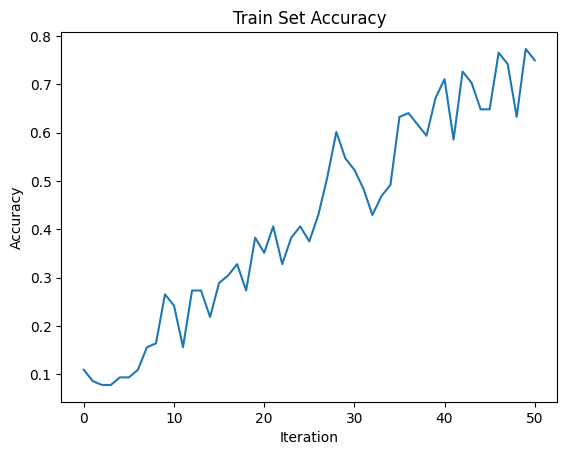

In [17]:
import matplotlib.pyplot as plt

# Plot Loss
fig = plt.figure(facecolor="w")
plt.plot(acc_hist)
plt.title("Train Set Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()

## 3.2 Spike Counter

Run a forward pass on a batch of data to obtain spike recordings.

In [18]:
spk_rec = forward_pass(net, data)

Changing `idx` allows you to index into various samples from the simulated minibatch. Use `splt.spike_count` to explore the spiking behaviour of a few different samples. Generating the following animation will take some time.

> Note: if you are running the notebook locally on your desktop, please uncomment the line below and modify the path to your ffmpeg.exe



The target label is: 4


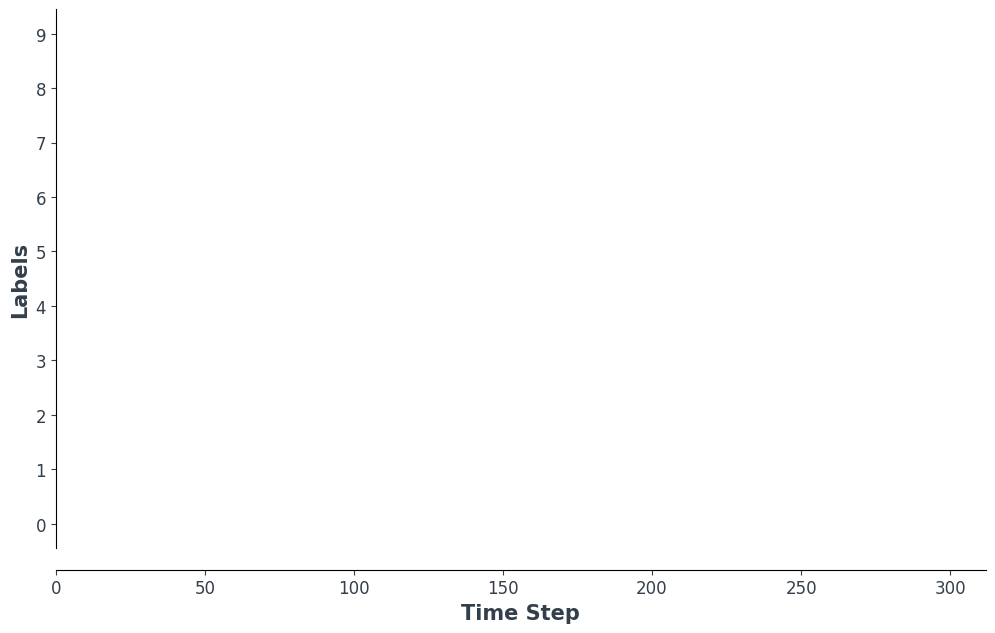

In [19]:
from IPython.display import HTML

idx = 0

fig, ax = plt.subplots(facecolor='w', figsize=(12, 7))
labels=['0', '1', '2', '3', '4', '5', '6', '7', '8','9']
print(f"The target label is: {targets[idx]}")

# plt.rcParams['animation.ffmpeg_path'] = 'C:\\path\\to\\your\\ffmpeg.exe'

#  Plot spike count histogram
anim = splt.spike_count(spk_rec[:, idx].detach().cpu(), fig, ax, labels=labels,
                        animate=True, interpolate=1)

HTML(anim.to_html5_video())
# anim.save("spike_bar.mp4")

# Conclusion
If you made it this far, then congratulations - you have the patience of a monk. You should now also understand how to load neuromorphic datasets using Tonic and then train a network using snnTorch.

This concludes the deep-dive tutorial series.
Check out the [advanced tutorials](https://snntorch.readthedocs.io/en/latest/tutorials/index.html) to learn more advanced techniques, such as introducing long-term temporal dynamics into our SNNs, population coding, or accelerating on Intelligence Processing Units.

If you like this project, please consider starring ⭐ the repo on GitHub as it is the easiest and best way to support it.


# Additional Resources
* [Check out the snnTorch GitHub project here.](https://github.com/jeshraghian/snntorch)
* [The Tonic GitHub project can be found here.](https://github.com/neuromorphs/tonic)
* The N-MNIST Dataset was originally published in the following paper: [Orchard, G.; Cohen, G.; Jayawant, A.; and Thakor, N.  “Converting Static Image Datasets to Spiking Neuromorphic Datasets Using Saccades", Frontiers in Neuroscience, vol.9, no.437, Oct. 2015.](https://www.frontiersin.org/articles/10.3389/fnins.2015.00437/full)
* For further information about how N-MNIST was created, please refer to [Garrick Orchard's website here.](https://www.garrickorchard.com/datasets/n-mnist)